In [224]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random
import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from textblob import TextBlob

from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection
from sklearn.inspection import permutation_importance

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

import xgboost as xgb
# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np
import matplotlib

In [225]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [226]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [227]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [228]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [229]:
df = get_samples(df,1000000)

In [230]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [231]:
df.shape

(1000000, 4)

In [232]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer
df['polarity'] = df['Q'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['Q'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

### In this part, I wanted to see how subjective or polar the questions are for each category

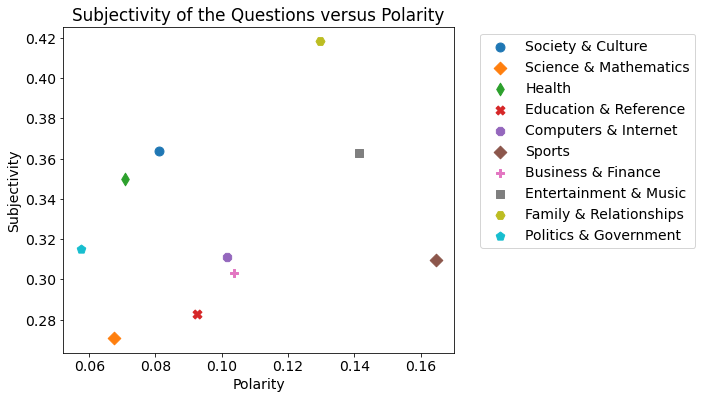

In [233]:
filled_markers = ('o', 'D', 'd', 'X','8', 'D','P','s','H', 'p')
fig,ax = plt.subplots(figsize=(7,6))
for i in range(1,11):
     ax.scatter(df[df.target==i]['polarity'].mean(),df[df.target==i]['subjectivity'].mean(),
                marker=filled_markers[i-1],label=target_classes[i-1],s=80,);

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
ax.set_xlabel('Polarity');
ax.set_ylabel('Subjectivity');
ax.set_title('Subjectivity of the Questions versus Polarity');

### In this section, I'm interested to see how many of the following words have been used in the sentence
* what
* how
* I
* is
* why
* can
* do
* does
* where
* my

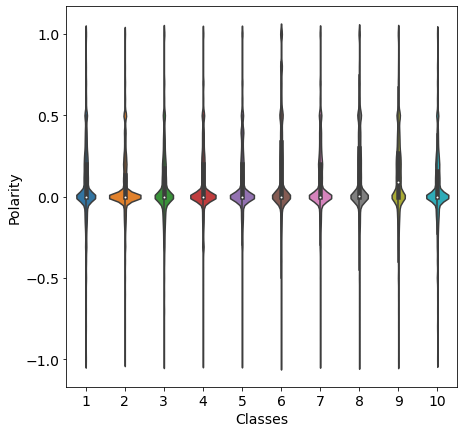

In [234]:
fig,ax=plt.subplots(figsize=(7,7));
ax = sns.violinplot(x='target',y='polarity', data=df , kind='swarm');
ax.set_xlabel('Classes');
ax.set_ylabel('Polarity');
matplotlib.rcParams.update({'font.size': 14})

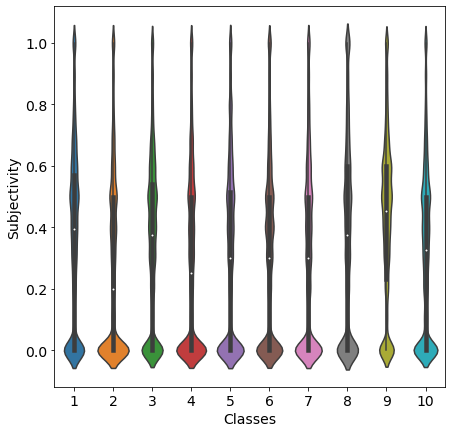

In [235]:
fig,ax=plt.subplots(figsize=(7,7));
ax = sns.violinplot(x='target',y='subjectivity', data=df , kind='swarm');
ax.set_xlabel('Classes');
ax.set_ylabel('Subjectivity');
matplotlib.rcParams.update({'font.size': 14})

In [236]:
df['what']= df['Q'].apply(lambda x:len(re.findall('what',str(x).lower())))
df['how'] = df['Q'].apply(lambda x:len(re.findall('how',str(x).lower())))
df['am']  = df['Q'].apply(lambda x:len(re.findall('am',str(x).lower())))
df['is']  = df['Q'].apply(lambda x:len(re.findall('is',str(x).lower())))
df['are'] = df['Q'].apply(lambda x:len(re.findall('are',str(x).lower())))
df['why'] = df['Q'].apply(lambda x:len(re.findall('why',str(x).lower())))
df['can'] = df['Q'].apply(lambda x:len(re.findall('can',str(x).lower())))
df['do']= df['Q'].apply(lambda x:len(re.findall('do',str(x).lower())))
df['does']= df['Q'].apply(lambda x:len(re.findall('does',str(x).lower())))
df['where']= df['Q'].apply(lambda x:len(re.findall('where',str(x).lower())))
df['who']= df['Q'].apply(lambda x:len(re.findall('who',str(x).lower())))

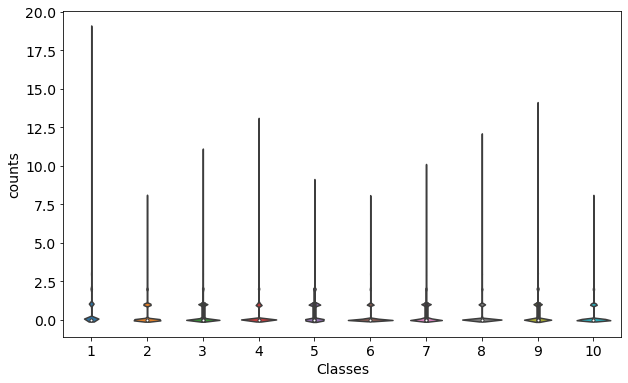

In [237]:
fig,axs = plt.subplots(figsize=(10,6));
axs = sns.violinplot(x='target',y='how', data=df , kind='swarm');
axs.set_xlabel('Classes');
axs.set_ylabel('counts');
matplotlib.rcParams.update({'font.size': 14})

In [238]:
df.groupby('target')[['what','who','why','how','where']].mean().round(2)

,what,who,why,how,where
target,,,,,
1,0.48,0.19,0.26,0.24,0.08
2,0.45,0.04,0.13,0.31,0.06
3,0.45,0.06,0.10,0.31,0.05
4,0.47,0.08,0.08,0.25,0.09
5,0.31,0.04,0.08,0.50,0.11
6,0.29,0.24,0.09,0.19,0.08
7,0.40,0.09,0.08,0.32,0.10
8,0.41,0.22,0.09,0.21,0.11
9,0.54,0.16,0.16,0.38,0.06


In [239]:
target_classes_dict

{1: 'Society & Culture',
 2: 'Science & Mathematics',
 3: 'Health',
 4: 'Education & Reference',
 5: 'Computers & Internet',
 6: 'Sports',
 7: 'Business & Finance',
 8: 'Entertainment & Music',
 9: 'Family & Relationships',
 10: 'Politics & Government'}

In [240]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,am,is,are,why,can,do,does,where,who
253615,7,can I fill out an application online for a sma...,,"To apply for grants, go to Grants.gov http://w...",can I fill out an application online for a sma...,can I fill out an application online for a sma...,-0.250000,0.400000,0,0,0,0,0,0,1,0,0,0,0
954160,1,Is Chinese difficult?,Is Chinese difficult?,English and Chinese are two different language...,Is Chinese difficult?Is Chinese difficult?,Is Chinese difficult?Is Chinese difficult?Engl...,-0.166667,0.333333,0,0,0,2,0,0,0,0,0,0,0
45279,7,"You, call a code. You, get the crash cart.?",,In the hospital when a patient is not breathin...,"You, call a code. You, get the crash cart.?","You, call a code. You, get the crash cart.?In...",0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0
265590,7,do I need to report form 5498 in my tax return?,,You only report this if you are a trustee or i...,do I need to report form 5498 in my tax return?,do I need to report form 5498 in my tax return...,0.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0
339769,10,"Looking for a leftist blog, which I thought wa...","I heard the blog name on Charlie Rose, but I t...",I think you're thinking of Daily Kos...a left ...,"Looking for a leftist blog, which I thought wa...","Looking for a leftist blog, which I thought wa...",0.016667,0.816667,0,0,1,1,0,0,0,0,0,0,0


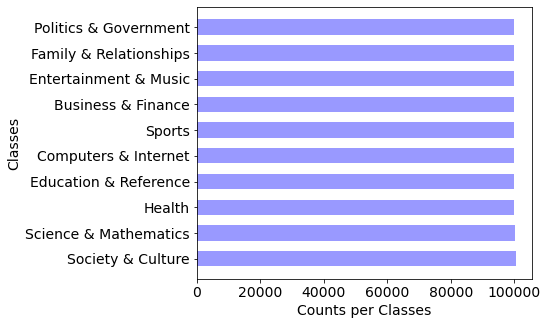

In [241]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [242]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [243]:
lst_stopwords = stopwords.words('english')+['else',"ya"]

In [244]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [245]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [246]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,am,is,are,why,can,do,does,where,who,Text_new
253615,7,can I fill out an application online for a sma...,,"To apply for grants, go to Grants.gov http://w...",can I fill out an application online for a sma...,can I fill out an application online for a sma...,-0.250000,0.400000,0,0,0,0,0,0,1,0,0,0,0,fill application online small business grant a...
954160,1,Is Chinese difficult?,Is Chinese difficult?,English and Chinese are two different language...,Is Chinese difficult?Is Chinese difficult?,Is Chinese difficult?Is Chinese difficult?Engl...,-0.166667,0.333333,0,0,0,2,0,0,0,0,0,0,0,chinese difficult chinese difficult english ch...
45279,7,"You, call a code. You, get the crash cart.?",,In the hospital when a patient is not breathin...,"You, call a code. You, get the crash cart.?","You, call a code. You, get the crash cart.?In...",0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,call code get crash cart hospital patient brea...
265590,7,do I need to report form 5498 in my tax return?,,You only report this if you are a trustee or i...,do I need to report form 5498 in my tax return?,do I need to report form 5498 in my tax return...,0.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0,need report form tax return report trustee iss...
339769,10,"Looking for a leftist blog, which I thought wa...","I heard the blog name on Charlie Rose, but I t...",I think you're thinking of Daily Kos...a left ...,"Looking for a leftist blog, which I thought wa...","Looking for a leftist blog, which I thought wa...",0.016667,0.816667,0,0,1,1,0,0,0,0,0,0,0,looking leftist blog thought dailycodes com he...


In [247]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [248]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,...,do,does,where,who,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
253615,7,can I fill out an application online for a sma...,,"To apply for grants, go to Grants.gov http://w...",can I fill out an application online for a sma...,can I fill out an application online for a sma...,-0.250000,0.400000,0,0,...,0,0,0,0,fill application online small business grant a...,186,1039,19,5.586022,9.789474
954160,1,Is Chinese difficult?,Is Chinese difficult?,English and Chinese are two different language...,Is Chinese difficult?Is Chinese difficult?,Is Chinese difficult?Is Chinese difficult?Engl...,-0.166667,0.333333,0,0,...,0,0,0,0,chinese difficult chinese difficult english ch...,154,738,18,4.792208,8.555556


In [249]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

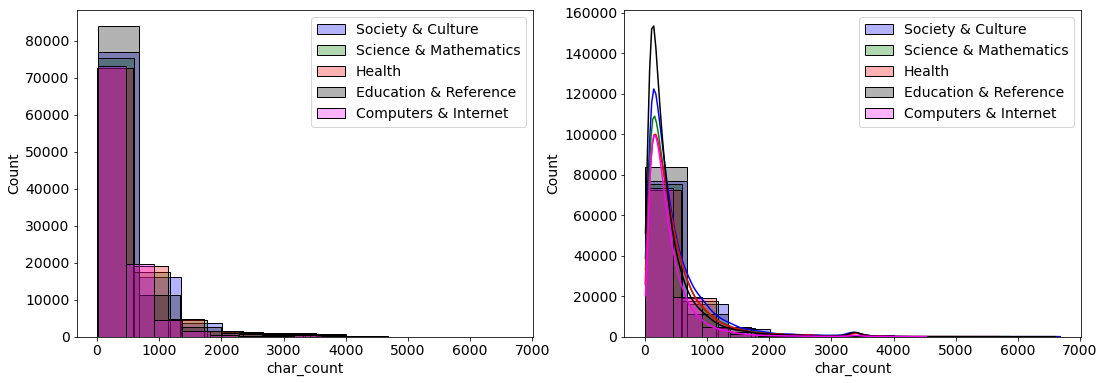

In [250]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [251]:
df.groupby('target').word_count.median()

target
1     71
2     66
3     76
4     51
5     59
6     45
7     53
8     41
9     75
10    73
Name: word_count, dtype: int64

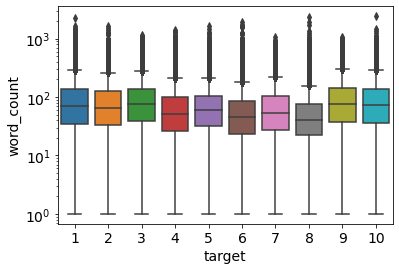

In [252]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

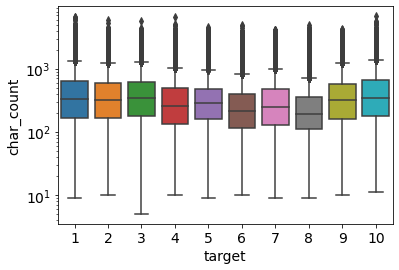

In [253]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

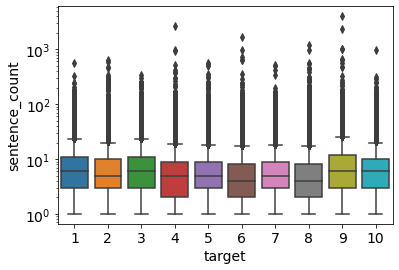

In [254]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

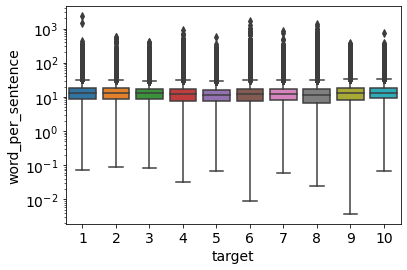

In [255]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [256]:
X = df.Text_new
y = df.target

In [257]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [258]:
vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

In [259]:
XX_train = vect.fit_transform(X_train)

In [260]:
XX_test = vect.transform(X_test)

In [261]:
vocab = vect.vocabulary_

In [262]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [263]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

9920

In [264]:
df_features.head(5)

,feature,Score,y
48,2x,1.0,1
110,abraham,1.0,1
127,accent,1.0,1
128,accept,1.0,1
129,acceptable,1.0,1


In [265]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 5669
2x,abraham,accent,accept,acceptable,accepted,accepting,according,account,acid,acknowledge,adam,adam eve,address,adultery,african,african american,agnostic,agree,allah,almighty,always,amen,american,among,ancestor,ancient,angel,animal,answer

category 2: Science & Mathematics
length of category 2: 7250
000,01,10,100,12,14,15,16,18,23,24,25,2a,2b,2x,2x 2x,2y,32,33,35,36,3a,3x,3y,4x,4y,5x,6x,75,7x

category 3: Health
length of category 3: 6708
ab,abdomen,abdominal,abnormal,account,ache,acid,acne,active,activity,acute,addicted,addiction,addictive,address,adhd,adult,adverse,advice,advise,aerobic,affect,affected,afterwards,age,ago,aid,album,alcohol,alcoholic

category 4: Education & Reference
length of category 4: 4809
10th,12th,2x,3x,4x,5x,6x,8th grade,abbreviation,abroad,academic,account,accounting,accredited,activity,adjective,admission,agriculture,aid,algebra,alphabet,analysis,ancient,answer,ap,apply,applying,architecture,art,articl

In [266]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [267]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(900000, 9920)

In [268]:
XX_test = vect.transform(X_test)

In [269]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [270]:
# Creating a cloud of words

In [271]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [272]:
Text = " ".join(df_features[df_features.y==10].feature[:30])
Text

'11 2x abortion abuse accident accountable accused acid act action administration advocate affair afghanistan agency agenda agree agreement air force aircraft al album alien alliance allow allowed ally amendment america american'

In [273]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

In [274]:
# plot_cloud(wordcloud)

## Finding the most frequent word in the corpus

In [275]:
cvec = CountVectorizer(vocabulary=X_names_unique,ngram_range=(1, 2),stop_words='english')

In [276]:
X_train_cvec = cvec.fit_transform(X_train)
sum_words = np.sum(X_train_cvec.todense(),axis=0)
popular_word = pd.DataFrame(data=sum_words.T,index=X_names_unique,columns=['word'])

In [277]:
popular_word = popular_word.sort_values(by='word',ascending=False)
selected_popular_word = popular_word[:10]

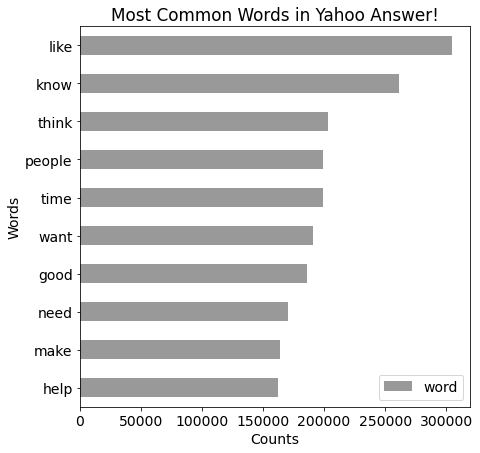

In [278]:
fig,ax=plt.subplots(figsize=(7,7))
selected_popular_word.plot.barh(color='black',alpha=0.4,ax=ax);
ax = plt.gca().invert_yaxis();
plt.title('Most Common Words in Yahoo Answer!');
plt.xlabel('Counts');
plt.ylabel('Words');

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [279]:
nb = naive_bayes.MultinomialNB()

In [280]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [281]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6788633333333334

In [282]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [283]:
## Test Classifier
Predicted_nb = nb.predict(XX_test)
Predicted_prob_nb = nb.predict_proba(XX_test)

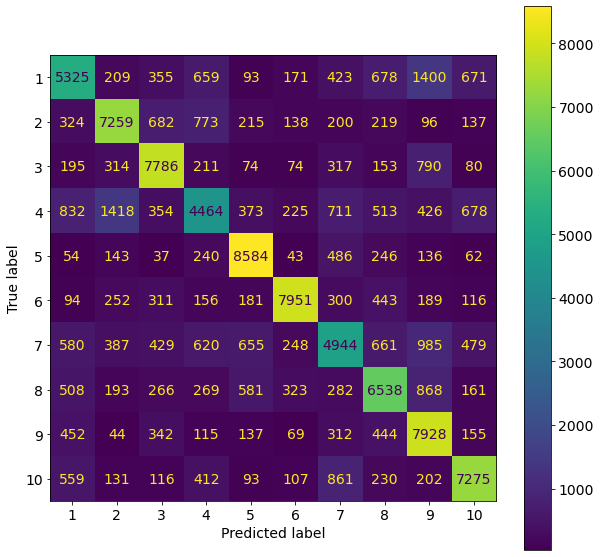

In [284]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

## Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [285]:
model_lr = LogisticRegression(max_iter=5000,n_jobs=-1)

In [286]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [ ]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

In [ ]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

In [ ]:
## Test Classifier
Predicted_lr = model_lr.predict(XX_test)
Predicted_prob_lr = model_lr.predict_proba(XX_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

In [ ]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted_lr)
auc = roc_auc_score(y_test,Predicted_prob_lr,multi_class='ovr')

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob_lr[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob_lr[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()

In [ ]:
feature_names = vect.get_feature_names()
coef_matrix = model_lr.coef_
dict_list=[]
for coef_row in coef_matrix:
    d={}
    for coef,fname in zip(coef_row,feature_names):
        d[fname] = coef
    sorted_values = list(reversed(sorted(d.values())))
    sorted_dict = {}
    for i in sorted_values:
        for k in d.keys():
            if d[k]==i:
                sorted_dict[k]=d[k]
                break
    dict_list.append(sorted_dict)

In [ ]:
def logistic_importance(ax,data,n_features,title):
    '''
    input: data : dictionary for the purpose of visualization
           ax : ax-object
    '''
    temp_data ={keys:values for (keys,values) in [x for x in data.items()][:n_features]}
    ax.barh(list(temp_data.keys()),list(temp_data.values()),color='b',alpha=0.4)
    ax.set_xlabel('Beta Coefficient')
    ax.set_ylabel('Feature Importance')
    ax.set_title(title)
    ax.invert_yaxis()

In [ ]:
fig,axs = plt.subplots(5,2,figsize=(12,25))
n_features = 8
for i,ax in enumerate(axs.ravel()):
    logistic_importance(ax,dict_list[i],n_features,target_classes[i])
fig.tight_layout()

In [ ]:
data = dict_list[5]
temp_data ={keys for (keys,values) in [x for x in data.items()][:20]}
Text = " ".join(temp_data)
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

In [ ]:
# plot_cloud(wordcloud)

In [ ]:
import circlify
d=[9,8,5,4,3]

In [ ]:
circlify.circlify(d)

In [ ]:
print(classification_report(y_test,Predicted_lr,target_names=target_classes))

## Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [ ]:
model_rf = RandomForestClassifier(n_estimators=1000,max_features=20,max_depth=40,n_jobs=-1)

In [ ]:
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [ ]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1).mean()

In [ ]:
training_scores=[]
test_scores=[]
# for tree in tree_list:
model_rf = RandomForestClassifier(n_estimators=1000,max_features=50,max_depth=300,n_jobs=-1)
model_rf.fit(XX_train,y_train)
training_scores.append(accuracy_score(y_train,model_rf.predict(XX_train)))
test_scores.append(accuracy_score(y_test,model_rf.predict(XX_test)))   

In [ ]:
training_scores

In [ ]:
test_scores

In [ ]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

In [ ]:
feature_names = list(X_names_unique)
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : model_rf.feature_importances_}, index=feature_names)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)[:20]
feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
ax = plt.gca().invert_yaxis()
leg = plt.legend( loc = 'lower right')


Creating permutation would take a long time. You can create one by uncommenting the following lines

In [ ]:
# results = permutation_importance(model_rf, XX_test.todense(), y_test, n_repeats=5, random_state=0)
# feature_scores = pd.DataFrame({'feature_importance_mean' : results.importances_mean}, index=feature_names)
# feature_scores = feature_scores.sort_values(by='feature_importance_mean', ascending=False)
# feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
# plt.gca().invert_yaxis()

## Gradient Boost
* Gradient boost is running so slow, not sugegsted at this time

In [ ]:
gb = GradientBoostingClassifier(max_depth=50)

In [ ]:
# cross_val_score(gb,XX_train,y_train,cv=5,n_jobs=-1).mean()

In [ ]:
# training_scores=[]
# test_scores=[]
# tree_list=[1000,1500]
# for tree in tree_list:
#     model_gb = GradientBoostingClassifier(n_estimators=tree,learning_rate=0.01)
#     model_gb.fit(XX_train,y_train)
#     training_scores.append(accuracy_score(y_train,model_gb.predict(XX_train)))
#     test_scores.append(accuracy_score(y_test,model_gb.predict(XX_test)))   

In [ ]:
parameters = {'n_estimators':[500,1000,1500,2000],
              'learning_rate':[0.1]}

In [ ]:
gb_tune = GridSearchCV(gb,param_grid=parameters,cv=2,scoring='accuracy',n_jobs=-1,verbose=2)

In [ ]:
# gb_tune.fit(XX_train,y_train)

## XGBOOST

In [ ]:
D_train = xgb.DMatrix(XX_train,label=y_train)
D_test  = xgb.DMatrix(XX_test,label=y_test)

In [ ]:
model_gb = xgb.XGBClassifier(n_estimators=1000, max_depth=50,learning_rate=0.01,objective='multi:softmax',gamma=0.2,n_jobs=-1)

In [ ]:
y_train_gb = y_train-1

In [ ]:
y_test_gb = y_test -1

In [ ]:
model_gb.fit(XX_train,y_train_gb)

In [ ]:
tt1 = model_gb.predict(XX_train)

In [ ]:
tt2 = model_gb.predict(XX_test)

In [ ]:
plot_confusion_matrix(model_gb,XX_test,y_test_gb);

In [ ]:
# cross_val_score(model_gb,XX_train,y_train,cv=5,n_jobs=-1).mean()

In [ ]:
accuracy_score(y_test_gb,model_gb.predict(XX_test))

### Binary Classification

* Tried to see how does binary classification works for one of the classes
* Can be useful if you need to convert the question into binary classification

In [ ]:
# y_train_binary = y_train.replace([1,2,3,4,6,7,8,9,10],0)
# y_train_binary = y_train_binary.replace(5,1)

In [ ]:
# y_test_binary = y_test.replace([1,2,3,4,6,7,8,9,10],0)
# y_test_binary = y_test_binary.replace(5,1)
# y_test_binary.value_counts()

In [ ]:
# model_lr = LogisticRegression(max_iter=5000,class_weight='balanced')

In [ ]:
# cross_val_score(model_lr,XX_train,y_train_binary,cv=5,n_jobs=-1).mean()
# model_lr.fit(XX_train,y_train_binary)

In [ ]:
# ## Test Classifier
# Predicted = model_lr.predict(XX_test)
# Predicted_prob = model_lr.predict_proba(XX_test)

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10));
# plot_confusion_matrix(model_lr,XX_test,y_test_binary,ax=ax);

### GridSearch CV
* Following lines used for gridsearchcv on the pipeline
* Fault problem in AWS is an issue
* use values less than -1 (e.g, -5) for this purpose

In [ ]:
# opt_model = pipeline.Pipeline([
#            ('vectopt', TfidfVectorizer()),
#            ('classifier', model_lr)])

In [ ]:
# parameters = {
#     'vectopt__max_df': (0.98, 1.0),
#     'vectopt__min_df': (0.01, 0.02 ),
#     'vectopt__max_features': (2000, 5000, 10000),
#     'vectopt__ngram_range': ((1, 1), (1, 2), (1,3))  
#                 }

In [ ]:
# # lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=2,verbose=1,scoring='accuracy',n_jobs=-1)
# lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=5,verbose=1,n_jobs=50)

In [ ]:
# lr_gs.fit(X_train,y_train)

In [ ]:
# e = pd.DataFrame(lr_gs.cv_results_)

In [ ]:
# e.sort_values(by='mean_test_score',axis=0,ascending=False)

### USE THE BELOW LINES FOR DEBUGGING

In [ ]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [ ]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

In [ ]:
X_test[(y_test!=Predicted) & (y_test==7)].index

In [ ]:
index_number = 43695

In [ ]:
X_test.loc[index_number]

In [ ]:
df.loc[index_number]

In [ ]:
df.loc[index_number]['Q&A']

In [ ]:
vocab

In [ ]:
test_set = 55
text = X_test.iloc[test_set]
text

In [ ]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

In [ ]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [ ]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=5,top_labels=1)

In [ ]:
explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
gg = model_lr.predict(XX_train)

In [ ]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train